# Blackjack: A Casino Banking Card Game

<div align="center">
    <img src="./images/blackjack_game.jpeg" width="300" alt="CartPole Environment">
</div>

**Game Rules:** Blackjack is a card game where the goal is to get as close to a sum of 21 as possible without going over. The player plays against a fixed dealer. The face cards (Jack, Queen, King) have a point value of 10. Aces can count as 1 or 11 (called 'usable' ace when counting as 11).

This notebook implements a Q-learning agent for playing Blackjack using Farama Gymnasium. The agent learns to make optimal decisions (hit or stand) based on the current game state to maximize its expected rewards.

## The Environment

Environment design for Blackjack in Gynmasium is as follows.

- **States:** Tuple containing play's hand value (int), value of dealer's face-up card (int), whether player holds a usable ace (bool)

- **Discrete Actions:** 0 (stand: keep current hand) or 1 (hit: take another card)

- **Q-values:** Expected rewards for each action in each state

- **Rewards:** +1.0 (for win), 0.0 (for draw) or -1.0 (lose) is rewarded at the end of each episode.

- **Episode Termination:** The episode ends when any of the condition holds true:
    - Player's sum goes over 21 (bust)
    - Player decides to stick
    - Player gets natural blackjack (21 from first two cards)

**Assumptions:** This verion of implementation assumes an infinite deck considering cards drawn with replacement.

**Sets up the environment**

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

# Create the Blackjack environment
env = gym.make('Blackjack-v1')

# Show environment details
print("Action Space:", env.action_space)
print("Observation Space:", env.observation_space)

Action Space: Discrete(2)
Observation Space: Tuple(Discrete(32), Discrete(11), Discrete(2))


## The BlackjackAgent

Now we'll implement the Q-learning agent with methods for action selection, Q-value updates, and exploration decay.

Q-learning builds a Q-table that tells the agent how good each action is in each situation. The table represents as follows.

- **Rows:** Different states (situations) the agent could be in any point in timestep
- **Columns:** Different actions the agent can take
- **Cell Values:** How good that action is in that state (Q-value)

The functionalities of the agent are

- **Choosing actions** (with both exploration and exploitation),
- **Learning from experience** (and updating Q-values in Q-table) and
- **Managing exploration** (by reducing exploration over time over ε-greedy strategy)

In [ ]:
class BlackjackAgent:
    def __init__(self, env, learning_rate=0.01, discount_factor=0.95,
                 initial_epsilon=1.0, epsilon_decay=0.99995, final_epsilon=0.01):
        """
        Initialize the Q-learning agent for Blackjack.
        
        Args:
            env: The Blackjack environment
            learning_rate: How quickly new information overrides old (α)
            discount_factor: How much future rewards are valued (γ)
            initial_epsilon: Starting exploration rate
            epsilon_decay: Rate at which exploration decreases
            final_epsilon: Minimum exploration rate
        """
        self.env = env
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        
        # Initialize Q-table with optimistic initial values
        self.q_table = defaultdict(lambda: np.zeros(env.action_space.n))
        
        # Track performance metrics
        self.training_rewards = []
        self.win_rates = []
        self.episode_lengths = []
    
    def get_action(self, state):
        """
        Choose action using ε-greedy policy.
        
        Args:
            state: Current state (player_sum, dealer_card, usable_ace)
            
        Returns:
            int: Chosen action (0: stand, 1: hit)
        """
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.q_table[state])
    
    def update_q_value(self, state, action, reward, next_state, terminated):
        """
        Update Q-value for state-action pair using the Bellman equation.
        
        Args:
            state: Current state
            action: Action taken
            reward: Reward received
            next_state: Next state
            terminated: Whether episode ended
        """
        best_next_value = 0 if terminated else np.max(self.q_table[next_state])
        target = reward + self.gamma * best_next_value
        current_q = self.q_table[state][action]
        self.q_table[state][action] = current_q + self.lr * (target - current_q)
    
    def decay_epsilon(self):
        """Decay exploration rate"""
        self.epsilon = max(self.final_epsilon, 
                          self.epsilon * self.epsilon_decay)
    
    def train(self, n_episodes):
        """
        Train the agent for specified number of episodes.
        
        Args:
            n_episodes: Number of episodes to train
        """
        wins = 0
        evaluation_interval = n_episodes // 100  # Evaluate every 1% of the training episodes
        
        for episode in range(n_episodes):
            state, _ = self.env.reset()
            state = tuple(state)  # Convert to tuple for dictionary key
            episode_reward = 0
            steps = 0
            
            # Play one episode
            done = False
            while not done:
                action = self.get_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                next_state = tuple(next_state)
                
                self.update_q_value(state, action, reward, next_state, terminated)
                
                state = next_state
                episode_reward += reward
                steps += 1
                done = terminated or truncated
            
            # Update metrics
            self.training_rewards.append(episode_reward)
            self.episode_lengths.append(steps)
            wins += (episode_reward > 0)
            
            # Decay exploration rate
            self.decay_epsilon()
            
            # Calculate and store win rate periodically
            if (episode + 1) % evaluation_interval == 0:
                win_rate = wins / evaluation_interval
                self.win_rates.append(win_rate)
                wins = 0
                
                # Print progress
                print(f"Episode {episode + 1}/{n_episodes}")
                print(f"Win Rate: {win_rate:.2%}")
                print(f"Average Reward: {np.mean(self.training_rewards[-evaluation_interval:]):.2f}")
                print(f"Epsilon: {self.epsilon:.3f}")
                print("--------------------")
    
    def evaluate(self, n_episodes):
        """
        Evaluate the trained agent's performance.
        
        Args:
            n_episodes: Number of episodes to evaluate
            
        Returns:
            float: Average reward over evaluation episodes
        """
        eval_rewards = []
        wins = 0
        
        for episode in range(n_episodes):
            state, _ = self.env.reset()
            state = tuple(state)
            episode_reward = 0
            done = False
            
            while not done:
                # Use learned policy (no exploration)
                action = np.argmax(self.q_table[state])
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                next_state = tuple(next_state)
                
                state = next_state
                episode_reward += reward
                done = terminated or truncated
            
            eval_rewards.append(episode_reward)
            wins += (episode_reward > 0)
        
        print(f"\nEvaluation Results (over {n_episodes} episodes):")
        print(f"Average Reward: {np.mean(eval_rewards):.2f}")
        print(f"Win Rate: {wins/n_episodes:.2%}")
        
        return np.mean(eval_rewards)

## Training the Agent

Now let's create and train our Blackjack agent.

In [3]:
# Create and train the agent
agent = BlackjackAgent(env,
                      learning_rate=0.01,
                      discount_factor=0.95,
                      initial_epsilon=1.0,
                      epsilon_decay=0.99995,
                      final_epsilon=0.01)

# Train for 100,000 episodes
agent.train(n_episodes=100000)

Episode 1000/100000
Win Rate: 28.00%
Average Reward: -0.41
Epsilon: 0.951
--------------------
Episode 2000/100000
Win Rate: 30.10%
Average Reward: -0.36
Epsilon: 0.905
--------------------
Episode 2000/100000
Win Rate: 30.10%
Average Reward: -0.36
Epsilon: 0.905
--------------------
Episode 3000/100000
Win Rate: 29.70%
Average Reward: -0.36
Epsilon: 0.861
--------------------
Episode 3000/100000
Win Rate: 29.70%
Average Reward: -0.36
Epsilon: 0.861
--------------------
Episode 4000/100000
Win Rate: 31.30%
Average Reward: -0.33
Epsilon: 0.819
--------------------
Episode 4000/100000
Win Rate: 31.30%
Average Reward: -0.33
Epsilon: 0.819
--------------------
Episode 5000/100000
Win Rate: 32.10%
Average Reward: -0.32
Epsilon: 0.779
--------------------
Episode 5000/100000
Win Rate: 32.10%
Average Reward: -0.32
Epsilon: 0.779
--------------------
Episode 6000/100000
Win Rate: 28.90%
Average Reward: -0.37
Epsilon: 0.741
--------------------
Episode 6000/100000
Win Rate: 28.90%
Average Rewar

## Evaluating the Trained Agent

Let's evaluate our trained agent's performance over 1000 episodes.

In [4]:
# Create environment for evaluation
eval_env = gym.make('Blackjack-v1', render_mode='human')

# Evaluate the agent
avg_reward = agent.evaluate(n_episodes=1000)

# Close the environment
eval_env.close()


Evaluation Results (over 1000 episodes):
Average Reward: -0.04
Win Rate: 42.60%


## Visualizing Training Progress

Let's create some plots to visualize how the agent learned over time.

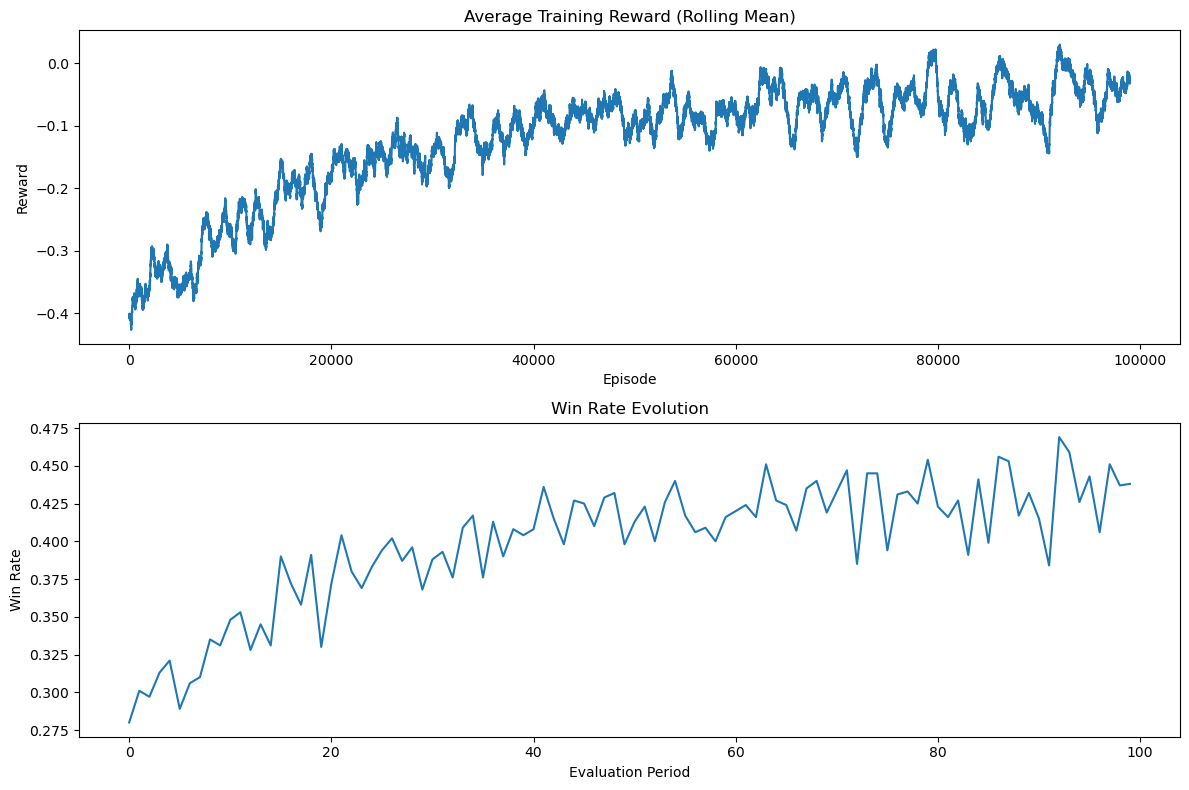

In [7]:
# Set up the plotting style
#plt.style.use('seaborn')

# Create a figure with multiple subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot training rewards
window_size = 1000
rolling_mean = np.convolve(agent.training_rewards, 
                          np.ones(window_size)/window_size, 
                          mode='valid')
ax1.plot(rolling_mean)
ax1.set_title('Average Training Reward (Rolling Mean)')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Reward')

# Plot win rates
ax2.plot(range(len(agent.win_rates)), agent.win_rates)
ax2.set_title('Win Rate Evolution')
ax2.set_xlabel('Evaluation Period')
ax2.set_ylabel('Win Rate')

plt.tight_layout()
plt.show()